In [1]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
cols="""duration,
protocol_type,
service,
flag,
src_bytes,
dst_bytes,
land,
wrong_fragment,
urgent,
hot,
num_failed_logins,
logged_in,
num_compromised,
root_shell,
su_attempted,
num_root,
num_file_creations,
num_shells,
num_access_files,
num_outbound_cmds,
is_host_login,
is_guest_login,
count,
srv_count,
serror_rate,
srv_serror_rate,
rerror_rate,
srv_rerror_rate,
same_srv_rate,
diff_srv_rate,
srv_diff_host_rate,
dst_host_count,
dst_host_srv_count,
dst_host_same_srv_rate,
dst_host_diff_srv_rate,
dst_host_same_src_port_rate,
dst_host_srv_diff_host_rate,
dst_host_serror_rate,
dst_host_srv_serror_rate,
dst_host_rerror_rate,
dst_host_srv_rerror_rate"""

columns=[]
for c in cols.split(','):
    if(c.strip()):
       columns.append(c.strip())

columns.append('target')
print(len(columns))

42


In [3]:
with open("training_attack_types",'r') as f:
    print(f.read())

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




In [4]:
attacks_types = {
    'normal': '1',
'back': '2',
'buffer_overflow': '3',
'ftp_write': '4',
'guess_passwd': '4',
'imap': '4',
'ipsweep': '5',
'land': '2',
'loadmodule': '3',
'multihop': '4',
'neptune': '2',
'nmap': '5',
'perl': '3',
'phf': '4',
'pod': '2',
'portsweep': '5',
'rootkit': '3',
'satan': '5',
'smurf': '2',
'spy': '4',
'teardrop': '2',
'warezclient': '4',
'warezmaster': '4',
}

In [5]:

path = "kddcup.data_10_percent.gz"
df = pd.read_csv(path,names=columns)
 
df['Attack Type'] = df.target.apply(lambda r:attacks_types[r[:-1]])

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,Attack Type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,1
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,1
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,1
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,1
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,1


In [6]:

num_cols = df._get_numeric_data().columns

cate_cols = list(set(df.columns)-set(num_cols))
cate_cols.remove('target')
cate_cols.remove('Attack Type')

cate_cols

['service', 'flag', 'protocol_type']

In [7]:
#This variable is highly correlated with num_compromised and should be ignored for analysis.
#(Correlation = 0.9938277978738366)
df.drop('num_root',axis = 1,inplace = True)

#This variable is highly correlated with serror_rate and should be ignored for analysis.
#(Correlation = 0.9983615072725952)
df.drop('srv_serror_rate',axis = 1,inplace = True)

#This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9947309539817937)
df.drop('srv_rerror_rate',axis = 1, inplace=True)

#This variable is highly correlated with srv_serror_rate and should be ignored for analysis.
#(Correlation = 0.9993041091850098)
df.drop('dst_host_srv_serror_rate',axis = 1, inplace=True)

#This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9869947924956001)
df.drop('dst_host_serror_rate',axis = 1, inplace=True)

#This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9821663427308375)
df.drop('dst_host_rerror_rate',axis = 1, inplace=True)

#This variable is highly correlated with rerror_rate and should be ignored for analysis.
#(Correlation = 0.9851995540751249)
df.drop('dst_host_srv_rerror_rate',axis = 1, inplace=True)

#This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
#(Correlation = 0.9865705438845669)
df.drop('dst_host_same_srv_rate',axis = 1, inplace=True)

In [8]:
pmap = {'icmp':0,'tcp':1,'udp':2}
df['protocol_type'] = df['protocol_type'].map(pmap)

In [9]:
fmap = {'SF':0,'S0':1,'REJ':2,'RSTR':3,'RSTO':4,'SH':5 ,'S1':6 ,'S2':7,'RSTOS0':8,'S3':9 ,'OTH':10}
df['flag'] = df['flag'].map(fmap)

In [10]:
df.drop('service',axis = 1,inplace= True)

In [11]:
Y = df[['Attack Type']]

In [12]:
lm = 16


In [13]:
a = len(df.columns)

In [14]:
b = a-lm

In [15]:
for i in range(b):
    df = df.iloc[:,:-1]

In [16]:
Y

,Attack Type
0,1
1,1
2,1
3,1
4,1
...,...
494016,1
494017,1
494018,1
494019,1


In [17]:
df

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_file_creations,num_shells
0,0,1,0,181,5450,0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,239,486,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,235,1337,0,0,0,0,0,1,0,0,0,0,0
3,0,1,0,219,1337,0,0,0,0,0,1,0,0,0,0,0
4,0,1,0,217,2032,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,1,0,310,1881,0,0,0,0,0,1,0,0,0,0,0
494017,0,1,0,282,2286,0,0,0,0,0,1,0,0,0,0,0
494018,0,1,0,203,1200,0,0,0,0,0,1,0,0,0,0,0
494019,0,1,0,291,1200,0,0,0,0,0,1,0,0,0,0,0


In [18]:
X = df

In [19]:
X = X.values.reshape(-1,4,4,1)

print("x_train shape: ",X.shape)

x_train shape:  (494021, 4, 4, 1)


In [20]:


from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y = to_categorical(Y, num_classes = 10)
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(330994, 4, 4, 1) (163027, 4, 4, 1)
(330994, 10) (163027, 10)


In [21]:
Y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [22]:
Y

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (4,4,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [24]:
model.add(Dense(10, activation = "softmax"))
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [25]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])



In [29]:
epochs = 100  # for better result increase the epochs
batch_size = 250

In [30]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [31]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/100
1323/1323 [==============================] - 81s 61ms/step - loss: 0.1400 - accuracy: 0.9652 - val_loss: 0.1359 - val_accuracy: 0.9670
Epoch 2/100
1323/1323 [==============================] - 82s 62ms/step - loss: 0.1381 - accuracy: 0.9651 - val_loss: 0.1383 - val_accuracy: 0.9662
Epoch 3/100
1323/1323 [==============================] - 82s 62ms/step - loss: 0.1358 - accuracy: 0.9654 - val_loss: 0.1323 - val_accuracy: 0.9664TA: 3s - loss: 0.1 - ETA: 2s -
Epoch 4/100
1323/1323 [==============================] - 83s 63ms/step - loss: 0.1341 - accuracy: 0.9654 - val_loss: 0.1298 - val_accuracy: 0.9664
Epoch 5/100
1323/1323 [==============================] - 83s 63ms/step - loss: 0.1325 - accuracy: 0.9657 - val_loss: 0.1257 - val_accuracy: 0.9666
Epoch 6/100
1323/1323 [==============================] - 83s 63ms/step - loss: 0.1312 - accuracy: 0.9659 - val_loss: 0.1219 - val_accuracy: 0.9670
Epoch 7/100
1323/1323 [==============================] - 84s 64ms/step - loss: 0.1291 - 

1323/1323 [==============================] - 84s 64ms/step - loss: 0.0976 - accuracy: 0.9732 - val_loss: 0.0850 - val_accuracy: 0.9763
Epoch 56/100
1323/1323 [==============================] - 84s 64ms/step - loss: 0.0979 - accuracy: 0.9733 - val_loss: 0.0855 - val_accuracy: 0.9771
Epoch 57/100
1323/1323 [==============================] - 83s 63ms/step - loss: 0.0976 - accuracy: 0.9733 - val_loss: 0.0850 - val_accuracy: 0.9757
Epoch 58/100
1323/1323 [==============================] - 84s 64ms/step - loss: 0.0973 - accuracy: 0.9733 - val_loss: 0.0967 - val_accuracy: 0.9763
Epoch 59/100
1323/1323 [==============================] - 84s 64ms/step - loss: 0.0965 - accuracy: 0.9735 - val_loss: 0.0850 - val_accuracy: 0.9764s: 0.0966 - accura - ETA: 2s - loss: 0.0965  - ETA: 1s - - ETA: 0s - loss: 0.096
Epoch 60/100
1323/1323 [==============================] - 83s 63ms/step - loss: 0.0974 - accuracy: 0.9733 - val_loss: 0.0878 - val_accuracy: 0.9763
Epoch 61/100
1323/1323 [=====================

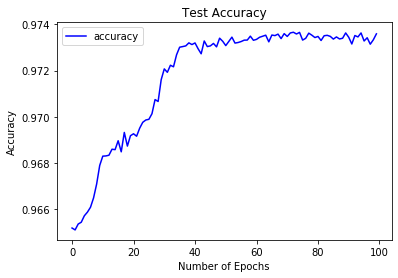

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['accuracy'], color='b', label="accuracy")
plt.title("Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()